In [87]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [88]:
def opening(img, kernel, e_it=1, d_it=1):   
    erosion = cv2.erode(img, kernel, iterations = e_it)
    dilation = cv2.dilate(erosion, kernel, iterations = d_it)
    
    return dilation

In [148]:
def find_limits(img, lb, ub):
    w, h = img.shape
    im_arr = np.reshape(img, (w*h))
    
    im_arr = np.sort(im_arr)
    
    i_a = int(round(w*h * lb, 0))
    i_b = int(round(w*h * ub, 0))
    
    a = im_arr[i_a-1]
    b = im_arr[i_b-1]
    
    t = find_t(im_arr, i_a, i_b)
    
    return a, b, t

def find_t(arr, ia, ib):
    a, b = arr[ia], arr[ib]
    
    interval = arr[ia:ib+1]
    mean_i = sum(interval) / len(interval)
    
    t = (2*mean_i*(b - a)) / (255*(a+b))
    print(t)
    
    return t

def nl_grayscale(img, lb, ub):
    new_a = 0
    new_b = 255
    a, b, t = find_limits(img, lb, ub)
    w, h = img.shape
    

    im_out = img.copy()
    
    i = img<a
    im_out[i] = new_a
    
    i = img > b
    im_out[i] = new_b
    
    
    for i in range(w):
        for j in range(h):
            if img[i, j] < a and not img[i, j] > b:
                new_a + ((new_a - new_b) / (a**t - b**t)) * (img[i, j]**t - a**t)
                
                
    #im_out[not img<b] = new_b
    #im_out[img<a and not img<b] = new_a
    
    return im_out

In [153]:
# The purpose of pre-processing is to reduce the variance in pixel intensities, while preserving the crack region.
# Ideally, this should make segmentation perform better, since the background becomes more uniform.

# Random images
# label_p = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000))
# label_n = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000))

# Specific images
label_p = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(148)
label_n = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(5550)

pos = cv2.imread(label_p)
neg = cv2.imread(label_n)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

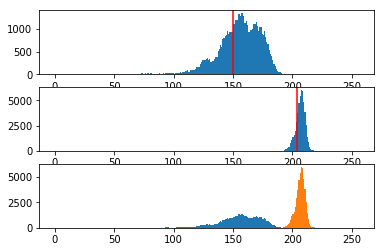

In [154]:
# Median Filtering 
m_pos = cv2.medianBlur(pos, 5)
m_neg = cv2.medianBlur(neg, 5)

# Grayscale Conversion
g_pos = cv2.cvtColor(m_pos, cv2.COLOR_BGR2GRAY)
g_neg = cv2.cvtColor(m_neg, cv2.COLOR_BGR2GRAY)

# Threshold
val_pos, bin_pos = cv2.threshold(g_pos, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
val_neg, bin_neg = cv2.threshold(g_neg, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Plot grayscale histograms
plt.figure()
plt.subplot(3, 1, 1)
plt.hist(g_pos.ravel(),256,[0,256])
plt.axvline(val_pos, color='r')
plt.subplot(3, 1, 2)
plt.hist(g_neg.ravel(),256,[0,256])
plt.axvline(val_neg, color='r')
plt.subplot(3, 1, 3)
plt.hist(g_pos.ravel(),256,[0,256])
plt.hist(g_neg.ravel(),256,[0,256])
plt.show()

In [155]:
# Pre-processing using opening (erosion -> erosion -> dilation)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

o_pos = opening(g_pos, kernel, 2, 1)
o_neg = opening(g_neg, kernel, 2, 1)

val_pos1, bin_pos1 = cv2.threshold(o_pos, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
val_neg1, bin_neg1 = cv2.threshold(g_neg, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

cv2.imshow("Grayscale", g_pos)
cv2.imshow("New Grayscale", o_pos)
cv2.imshow("Neg Grayscale", g_neg)
cv2.imshow("Neg New Grayscale", o_neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

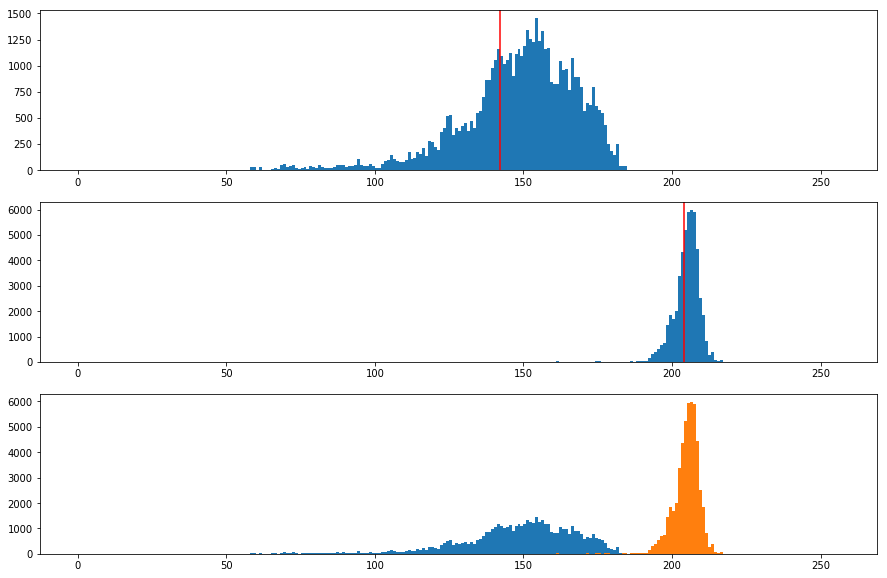

In [156]:
plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.hist(o_pos.ravel(),256,[0,256])
plt.axvline(val_pos1, color='r')
plt.subplot(3, 1, 2)
plt.hist(o_neg.ravel(),256,[0,256])
plt.axvline(val_neg1, color='r')
plt.subplot(3, 1, 3)
plt.hist(o_pos.ravel(),256,[0,256])
plt.hist(o_neg.ravel(),256,[0,256])
plt.show()

150.0
142.0


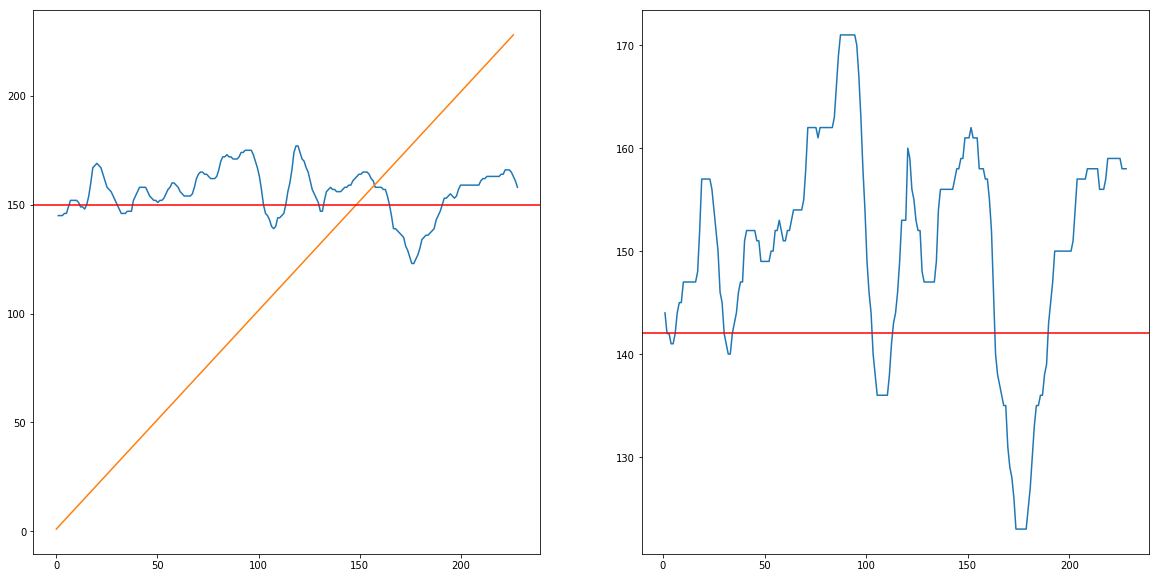

In [157]:
# Variance comparison: 

w, h = g_pos.shape

x = np.linspace(1, w+1, w)
old_y = g_pos[155]
new_y = o_pos[155]

print(val_pos)
print(val_pos1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(x, old_y, x)
plt.axhline(val_pos, color='r')
plt.subplot(1,2,2)
plt.plot(x, new_y)
plt.axhline(val_pos1, color='r')
plt.show()

In [158]:
cv2.imshow("Grayscale", g_pos)
cv2.imshow("No pre-processing", bin_pos)
cv2.imshow("Pre-processing", bin_pos1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [159]:
out_p = opening(bin_pos, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), 1, 0)
out_n = opening(bin_neg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), 1, 0)


cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("NPos", out_p)
cv2.imshow("Neg", out_n)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [160]:
pp = round(np.count_nonzero(out_p)/(227*227), 4)
pn = round(np.count_nonzero(out_n)/(227*227), 4)

nl_pos = nl_grayscale(o_pos, 0.02, pp)
nl_neg = nl_grayscale(o_neg, 0.02, pn)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("Pos", nl_pos)
cv2.imshow("Neg", nl_neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.1861553730192037
0.078308934320529


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
